# Kaggle House Price Prediction

In this notebook, I used the XGBoost Regressor along with [RFECV](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) to rank the importance of the features and eliminate the redundant ones. I then trained a Kernel Ridge regressor (which performed best among the several models I tried) to make predictions, which leads to a [leaderboard score](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard) of 0.11709.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.stats import uniform

from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer 

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# load the data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df = df_train.append(df_test , ignore_index = True)

# basic inspection
df_train.shape, df_test.shape, df_train.columns.values

((1460, 81),
 (1459, 80),
 array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
        'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
        'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
        'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
        'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
        'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',

## Data Preprocessing ##

Since the final result is evaluated using the Root-Mean-Squared-Error (RMSE) of the logarithm of the predicted house prices, it would be a good idea to log-transform ``SalePrice``. At the end of the code, I will transform my final predictions back to the real values for the output csv file. 

In [2]:
df.SalePrice = np.log(df.SalePrice)

Now I will first take care of NANs.

In [3]:
# divide the data into numerical ("quan") and categorical ("qual") features
quan = list( df_test.loc[:,df_test.dtypes != 'object'].drop('Id',axis=1).columns.values )
qual = list( df_test.loc[:,df_test.dtypes == 'object'].columns.values )

In [4]:
# Find out how many missing values there are for the quantitative and categorical features
hasNAN = df[quan].isnull().sum()
hasNAN = hasNAN[hasNAN > 0]
hasNAN = hasNAN.sort_values(ascending=False)
print(hasNAN)
print('**'*40)
hasNAN = df[qual].isnull().sum()
hasNAN = hasNAN[hasNAN > 0]
hasNAN = hasNAN.sort_values(ascending=False)
print(hasNAN)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64
********************************************************************************
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Functional         2
Utilities          2
Exterior1st        1
SaleType           1
Exterior2nd        1
KitchenQual        1
Electrical         1
dtype: int64


In [5]:
# Filling missing values for numerical features. Most of the NAN should mean that 
# the corresponding facillity/structure doesn't exist, so I use zero for most cases

df.LotFrontage.fillna(df.LotFrontage.median(), inplace=True)

# NAN should mean no garage. I temporarily use yr = 0 here. Will come back to this later. 
df.GarageYrBlt.fillna(0, inplace=True)

# Use zero
df.MasVnrArea.fillna(0, inplace=True)    
df.BsmtHalfBath.fillna(0, inplace=True)
df.BsmtFullBath.fillna(0, inplace=True)
df.GarageArea.fillna(0, inplace=True)
df.GarageCars.fillna(0, inplace=True)    
df.TotalBsmtSF.fillna(0, inplace=True)   
df.BsmtUnfSF.fillna(0, inplace=True)     
df.BsmtFinSF2.fillna(0, inplace=True)    
df.BsmtFinSF1.fillna(0, inplace=True)    

In [6]:
# Filling missing values for categorical features
df.PoolQC.fillna('NA', inplace=True)
df.MiscFeature.fillna('NA', inplace=True)    
df.Alley.fillna('NA', inplace=True)          
df.Fence.fillna('NA', inplace=True)         
df.FireplaceQu.fillna('NA', inplace=True)    
df.GarageCond.fillna('NA', inplace=True)    
df.GarageQual.fillna('NA', inplace=True)     
df.GarageFinish.fillna('NA', inplace=True)   
df.GarageType.fillna('NA', inplace=True)     
df.BsmtExposure.fillna('NA', inplace=True)     
df.BsmtCond.fillna('NA', inplace=True)        
df.BsmtQual.fillna('NA', inplace=True)        
df.BsmtFinType2.fillna('NA', inplace=True)     
df.BsmtFinType1.fillna('NA', inplace=True)     
df.MasVnrType.fillna('None', inplace=True)   
df.Exterior2nd.fillna('None', inplace=True) 

# These are general properties that all houses should have, so NANs probably 
# just mean the values were not recorded. I therefore use "mode", the most 
# common value to fill in
df.Functional.fillna(df.Functional.mode()[0], inplace=True)       
df.Utilities.fillna(df.Utilities.mode()[0], inplace=True)          
df.Exterior1st.fillna(df.Exterior1st.mode()[0], inplace=True)        
df.SaleType.fillna(df.SaleType.mode()[0], inplace=True)                
df.KitchenQual.fillna(df.KitchenQual.mode()[0], inplace=True)        
df.Electrical.fillna(df.Electrical.mode()[0], inplace=True)    

# MSZoning should highly correlate with the location, so I use the mode values of individual 
# Neighborhoods
for i in df.Neighborhood.unique():
    if df.MSZoning[df.Neighborhood == i].isnull().sum() > 0:
        df.loc[df.Neighborhood == i,'MSZoning'] = \
        df.loc[df.Neighborhood == i,'MSZoning'].fillna(df.loc[df.Neighborhood == i,'MSZoning'].mode()[0]) 


Now there are no NANs anymore, so we can further transform some of the features.

In [7]:
# These categorical features are "rank", so they can be transformed to 
# numerical features
df.Alley = df.Alley.map({'NA':0, 'Grvl':1, 'Pave':2})
df.BsmtCond =  df.BsmtCond.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.BsmtExposure = df.BsmtExposure.map({'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
df['BsmtFinType1'] = df['BsmtFinType1'].map({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df['BsmtFinType2'] = df['BsmtFinType2'].map({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df.BsmtQual = df.BsmtQual.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.ExterCond = df.ExterCond.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.ExterQual = df.ExterQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.FireplaceQu = df.FireplaceQu.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.Functional = df.Functional.map({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8})
df.GarageCond = df.GarageCond.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.GarageQual = df.GarageQual.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.HeatingQC = df.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.KitchenQual = df.KitchenQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.LandSlope = df.LandSlope.map({'Sev':1, 'Mod':2, 'Gtl':3}) 
df.PavedDrive = df.PavedDrive.map({'N':1, 'P':2, 'Y':3})
df.PoolQC = df.PoolQC.map({'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
df.Street = df.Street.map({'Grvl':1, 'Pave':2})
df.Utilities = df.Utilities.map({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4})

# Update my lists of numerical and categorical features
newquan = ['Alley','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual',
           'ExterCond','ExterQual','FireplaceQu','Functional','GarageCond',
           'GarageQual','HeatingQC','KitchenQual','LandSlope','PavedDrive','PoolQC',
           'Street','Utilities']
quan = quan + newquan 
for i in newquan: qual.remove(i)


# This is actually a categorical feature
df.MSSubClass = df.MSSubClass.map({20:'class1', 30:'class2', 40:'class3', 45:'class4',
                                   50:'class5', 60:'class6', 70:'class7', 75:'class8',
                                   80:'class9', 85:'class10', 90:'class11', 120:'class12',
                                   150:'class13', 160:'class14', 180:'class15', 190:'class16'})

# Keeping "YrSold" is enough
df=df.drop('MoSold',axis=1)

# Update my lists of numerical and categorical features
quan.remove('MoSold')
quan.remove('MSSubClass')
qual.append('MSSubClass')

For all the time variables, what matters should be the time duration. So I create three features: the age of the house (``Age``), the time duration since the remodel date (``AgeRemod``), and the age of the Garage (``AgeGarage``)

In [8]:
df['Age'] = df.YrSold - df.YearBuilt
df['AgeRemod'] = df.YrSold - df.YearRemodAdd
df['AgeGarage'] = df.YrSold - df.GarageYrBlt

# For the houses without a Garage, I filled the NANs with zeros, which makes AgeGarage ~ 2000
# Here I replace their AgeGarage with the maximum value among the houses with Garages
max_AgeGarage = np.max(df.AgeGarage[df.AgeGarage < 1000])
df['AgeGarage'] = df['AgeGarage'].map(lambda x: max_AgeGarage if x > 1000 else x)

# Some of the values are negative because the work was done after the house 
# was sold. In these cases, I change them to zero to avoid negative ages.
df.Age = df.Age.map(lambda x: 0 if x < 0 else x)
df.AgeRemod = df.AgeRemod.map(lambda x: 0 if x < 0 else x)
df.AgeGarage = df.AgeGarage.map(lambda x: 0 if x < 0 else x)

# drop the original time variables 
df=df.drop(['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1)

# update my list of numerical feature
for i in ['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']: quan.remove(i)
quan = quan + ['Age','AgeRemod','AgeGarage']

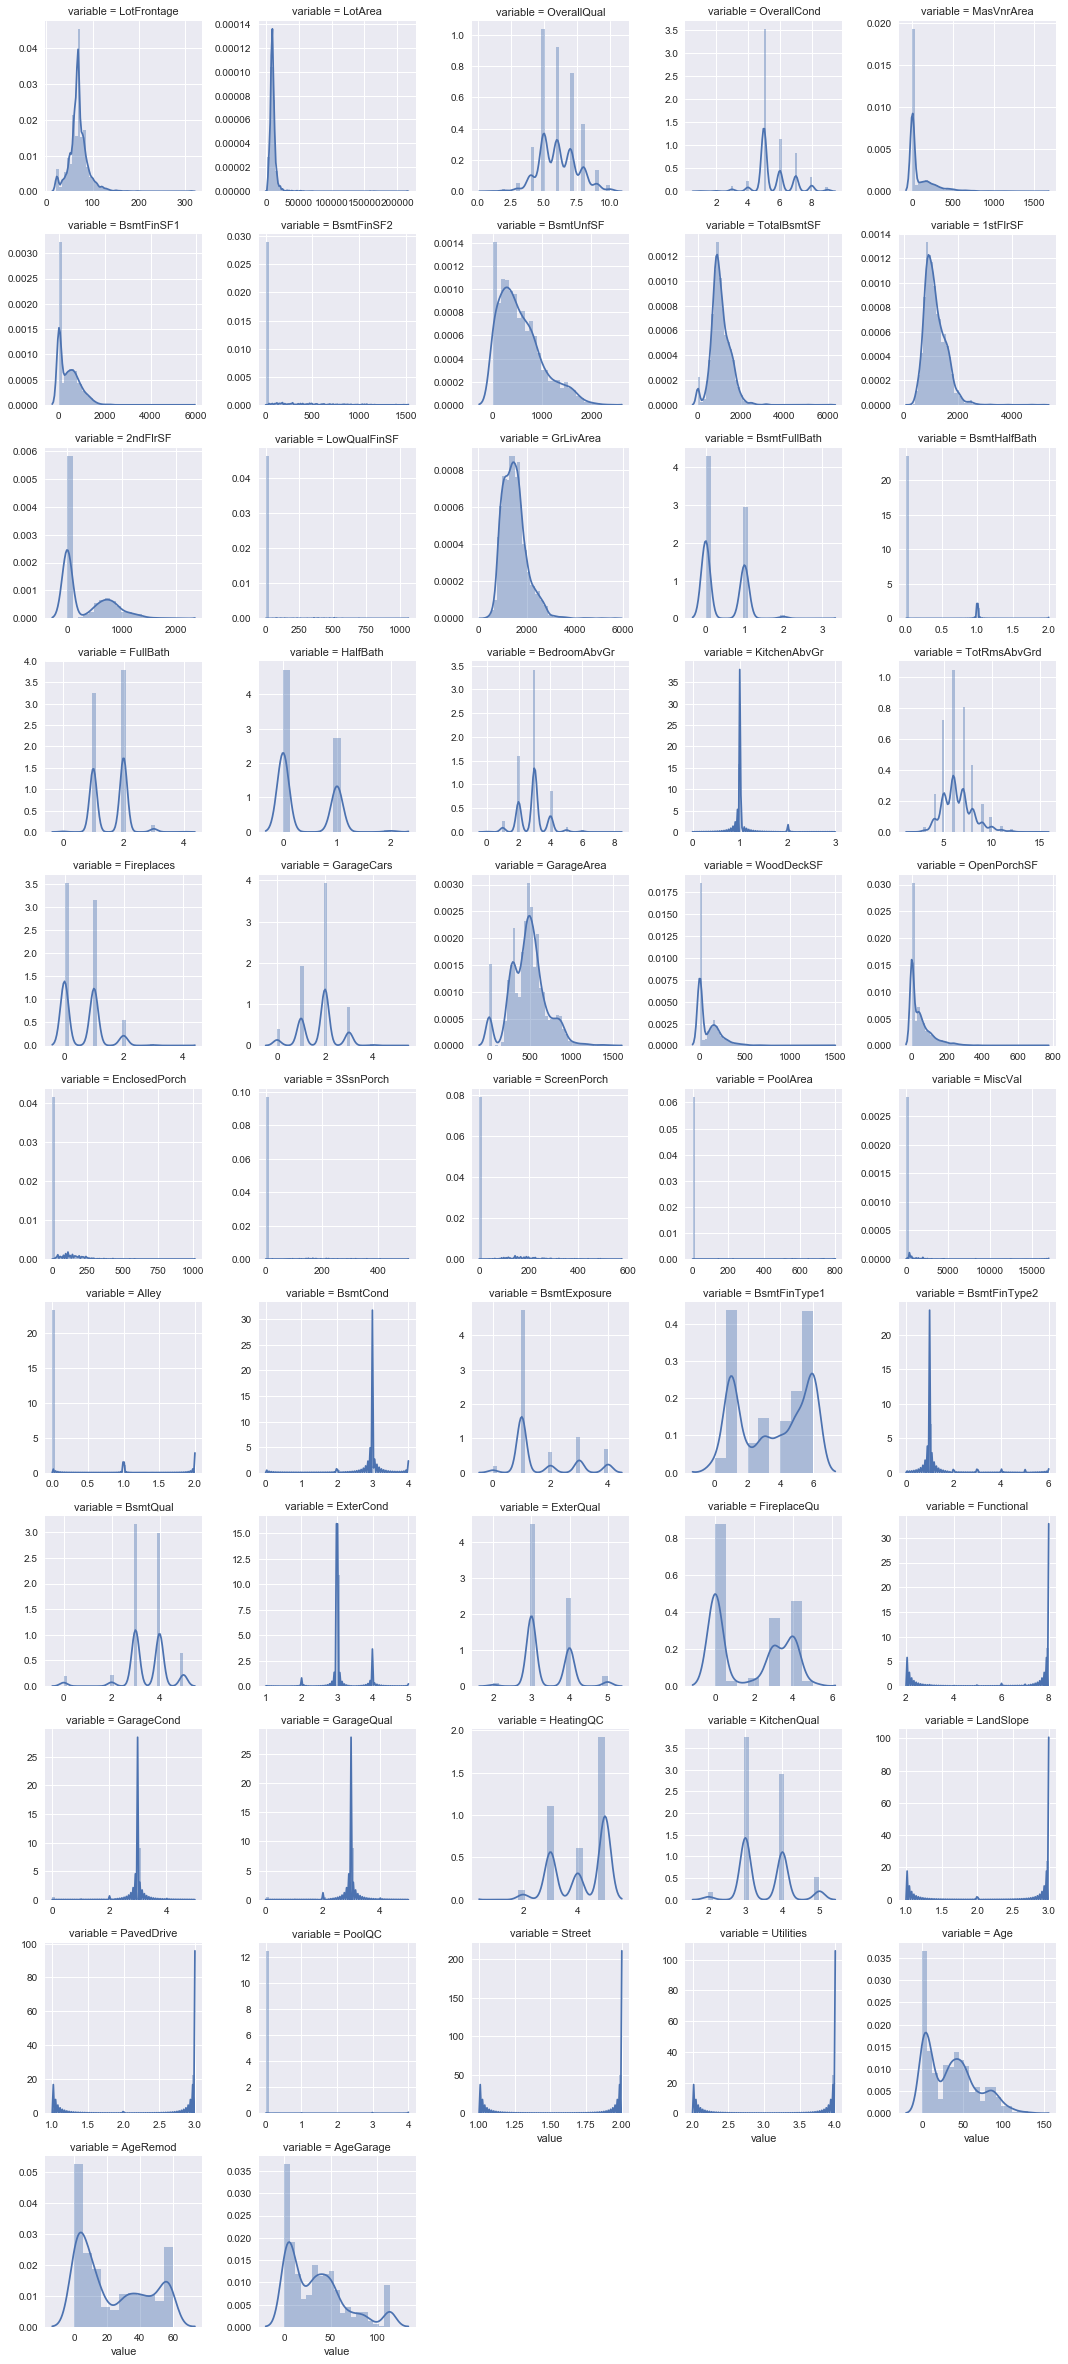

In [9]:
# visualize the distribution of each numerical feature
temp = pd.melt(df.drop('SalePrice',axis=1), value_vars=quan)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , size=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()

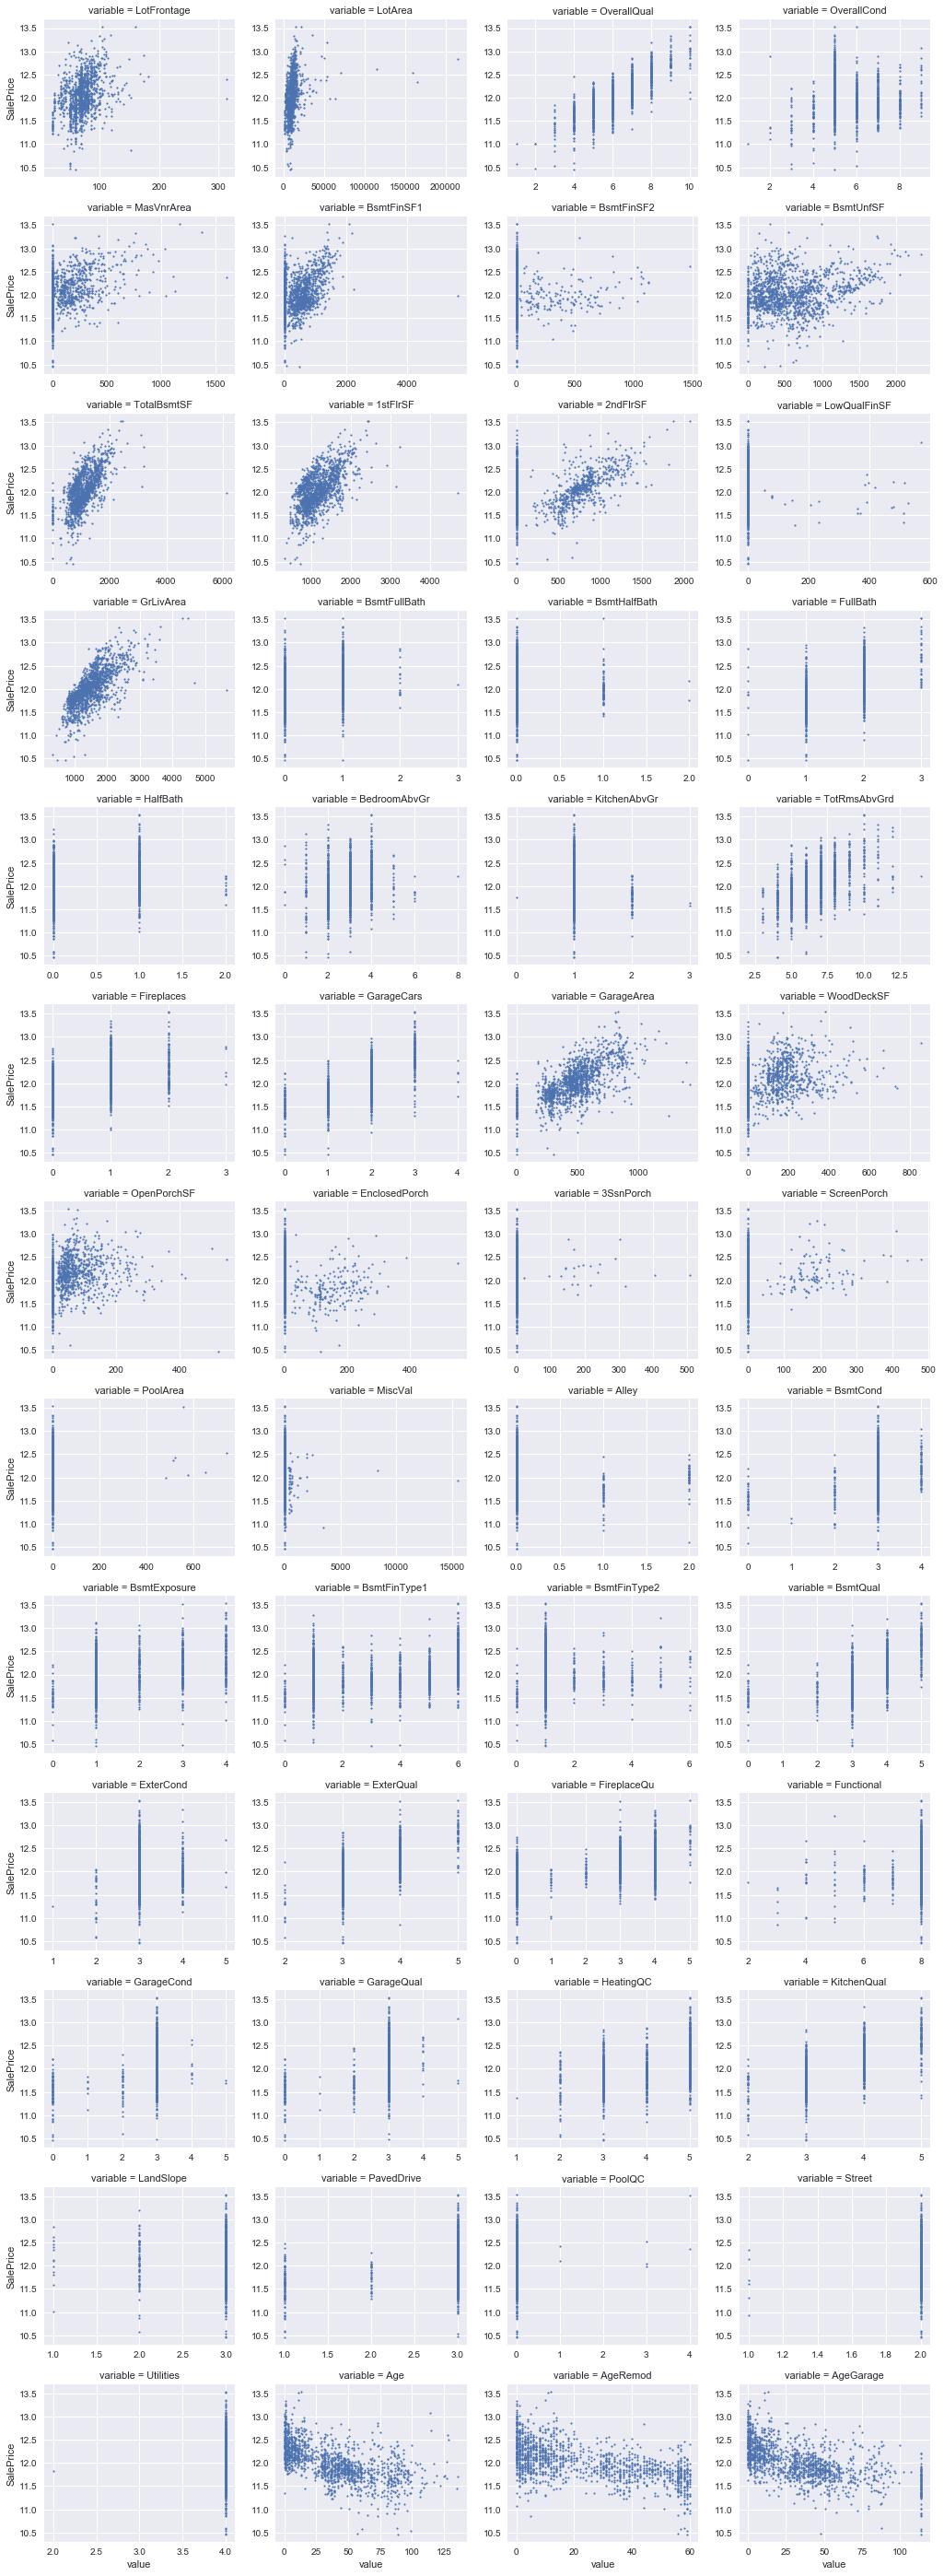

In [10]:
# scatter plots
temp = pd.melt(df, id_vars=['SalePrice'],value_vars=quan)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=4 , size=3.0, 
                     aspect=1.2,sharex=False, sharey=False)
grid.map(plt.scatter, "value",'SalePrice', s=3)
plt.show()

We see correlations in the scatter plots for some features, such as ``LotFrontage``, ``LotArea``, ``TotalBsmtSF``...etc. There are some obvious outliers in some of these plots. By removing some outliers in the training set, the model will generalize better on unseen data.

In [11]:
# These are somewhat arbitrary 
index_drop = df.LotFrontage[df.LotFrontage > 300].index
index_drop = np.append(index_drop, df.LotArea[df.LotArea > 100000].index)
index_drop = np.append(index_drop, df.BsmtFinSF1[df.BsmtFinSF1 > 4000].index)
index_drop = np.append(index_drop, df.TotalBsmtSF[df.TotalBsmtSF > 6000].index)
index_drop = np.append(index_drop, df['1stFlrSF'][df['1stFlrSF'] > 4000].index)
index_drop = np.append(index_drop, df.GrLivArea[(df.GrLivArea > 4000) & (df.SalePrice < 13)].index)
index_drop = np.unique(index_drop)

# make sure we only remove data from the training set
index_drop = index_drop[index_drop < 1460] 

df = df.drop(index_drop).reset_index(drop=True)
print("{} examples in the training set are dropped.".format(len(index_drop)))

7 examples in the training set are dropped.


Being inspired by [this blog](http://shahramabyari.com/), it is necessary to transform the numerical features that are skewed. This is because lots of regression models building assume that the features are distributed normally and have a symmetrical shape.

In [12]:
# print the skewness of each numerical feature
for i in quan:
    print(i+': {}'.format(round(skew(df[i]),2)))

LotFrontage: 0.76
LotArea: 3.6
OverallQual: 0.19
OverallCond: 0.57
MasVnrArea: 2.63
BsmtFinSF1: 0.98
BsmtFinSF2: 4.16
BsmtUnfSF: 0.92
TotalBsmtSF: 0.67
1stFlrSF: 1.26
2ndFlrSF: 0.86
LowQualFinSF: 12.07
GrLivArea: 1.07
BsmtFullBath: 0.62
BsmtHalfBath: 3.94
FullBath: 0.17
HalfBath: 0.69
BedroomAbvGr: 0.33
KitchenAbvGr: 4.3
TotRmsAbvGrd: 0.75
Fireplaces: 0.73
GarageCars: -0.22
GarageArea: 0.22
WoodDeckSF: 1.84
OpenPorchSF: 2.53
EnclosedPorch: 4.0
3SsnPorch: 11.36
ScreenPorch: 3.94
PoolArea: 17.67
MiscVal: 21.94
Alley: 4.13
BsmtCond: -3.6
BsmtExposure: 1.12
BsmtFinType1: -0.15
BsmtFinType2: 3.16
BsmtQual: -1.27
ExterCond: 1.31
ExterQual: 0.78
FireplaceQu: 0.18
Functional: -4.96
GarageCond: -3.38
GarageQual: -3.26
HeatingQC: -0.55
KitchenQual: 0.44
LandSlope: -4.98
PavedDrive: -2.97
PoolQC: 20.32
Street: -16.18
Utilities: -53.94
Age: 0.6
AgeRemod: 0.45
AgeGarage: 0.97


I've tried various transformations (log, boxcox, sqrt...etc) and found that log-transform works better.

In [13]:
# transform those with skewness > 0.5
skewed_features = np.array(quan)[np.abs(skew(df[quan])) > 0.5]
df[skewed_features] = np.log1p(df[skewed_features])

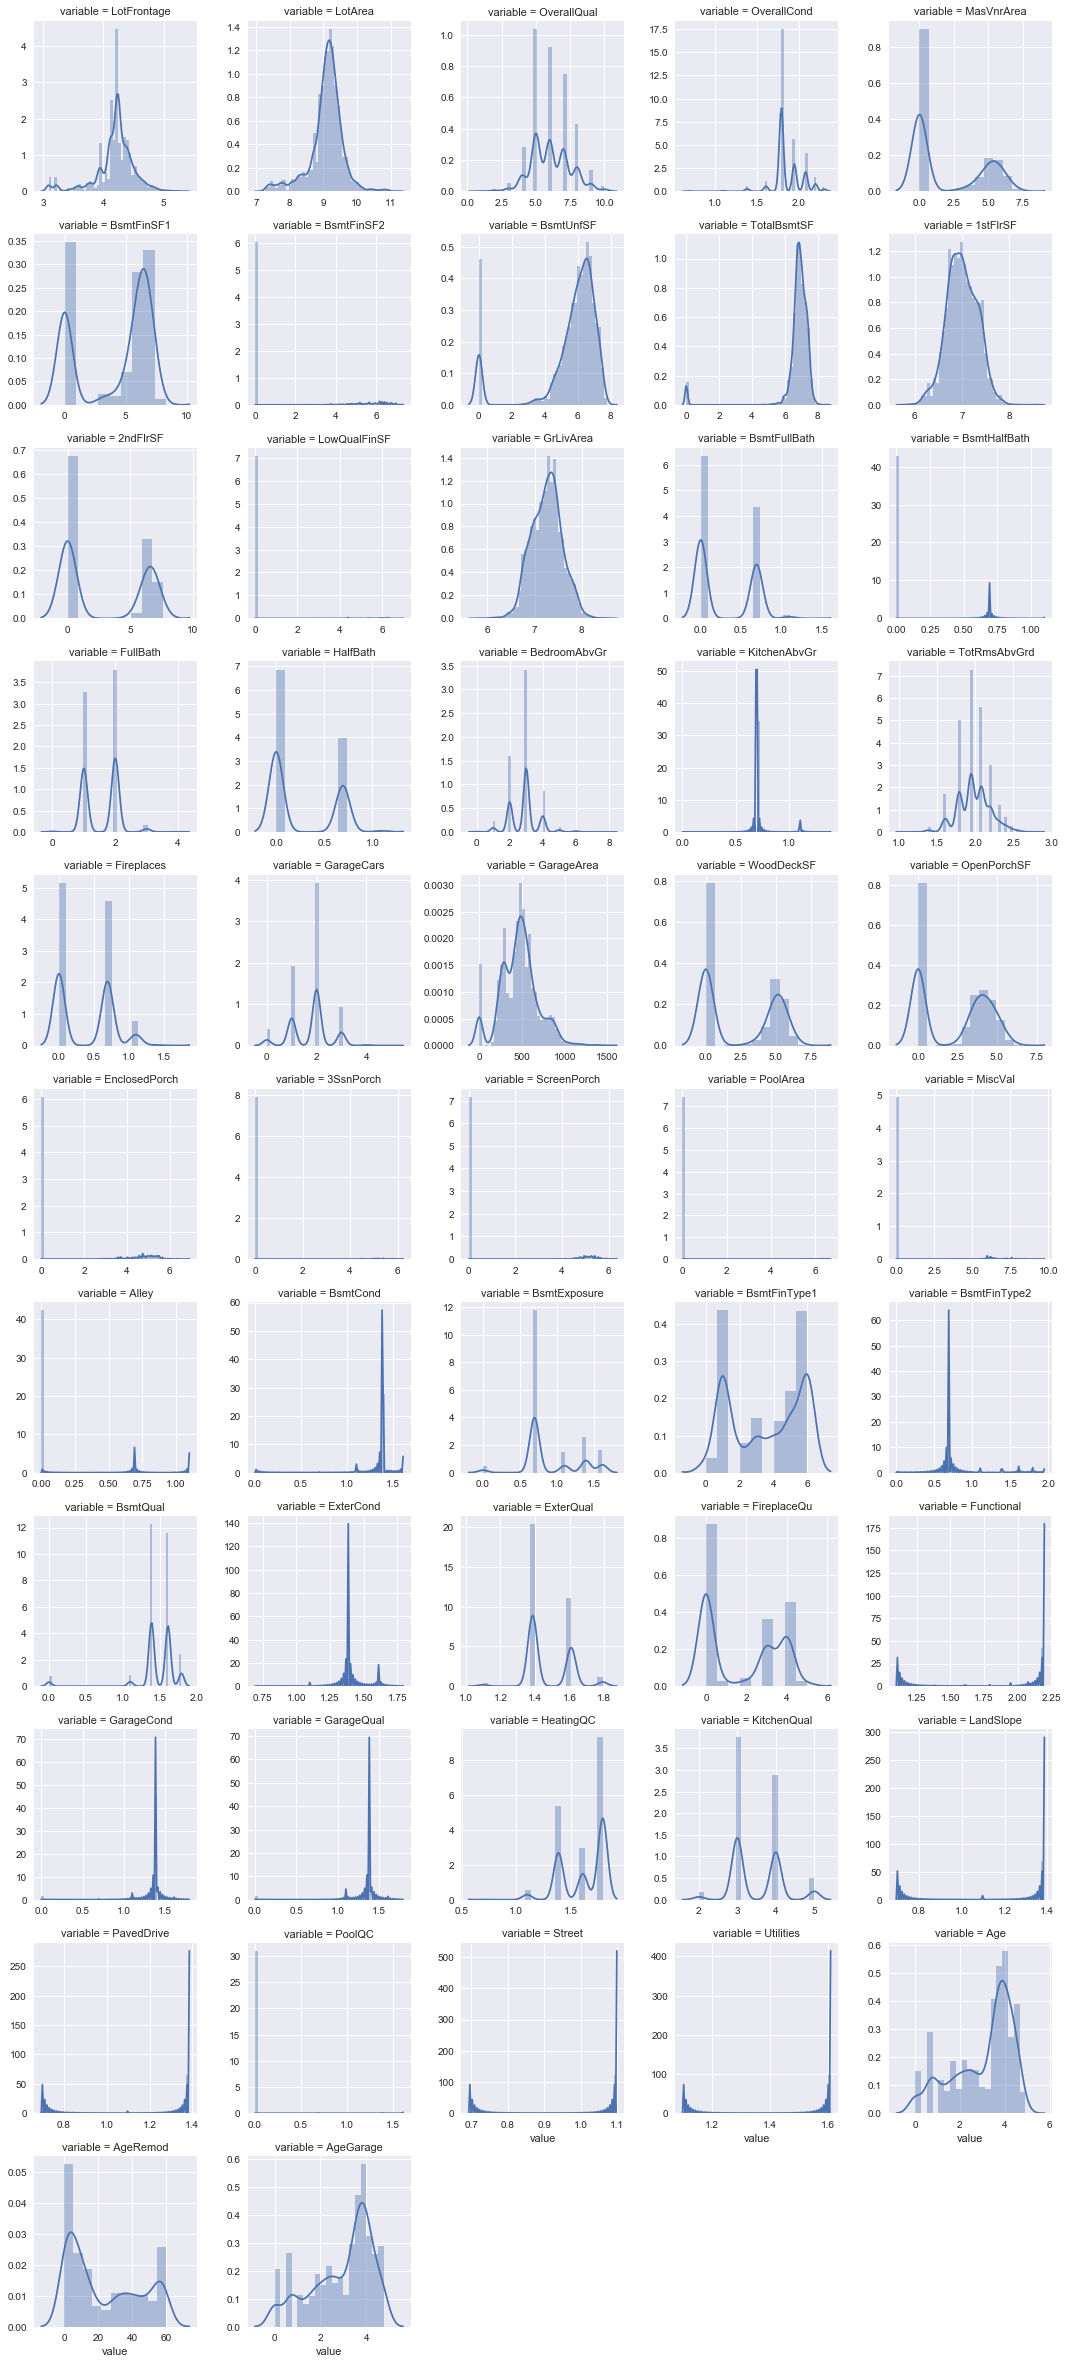

In [14]:
## visualize the distribution again
temp = pd.melt(df, value_vars=quan)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , size=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()

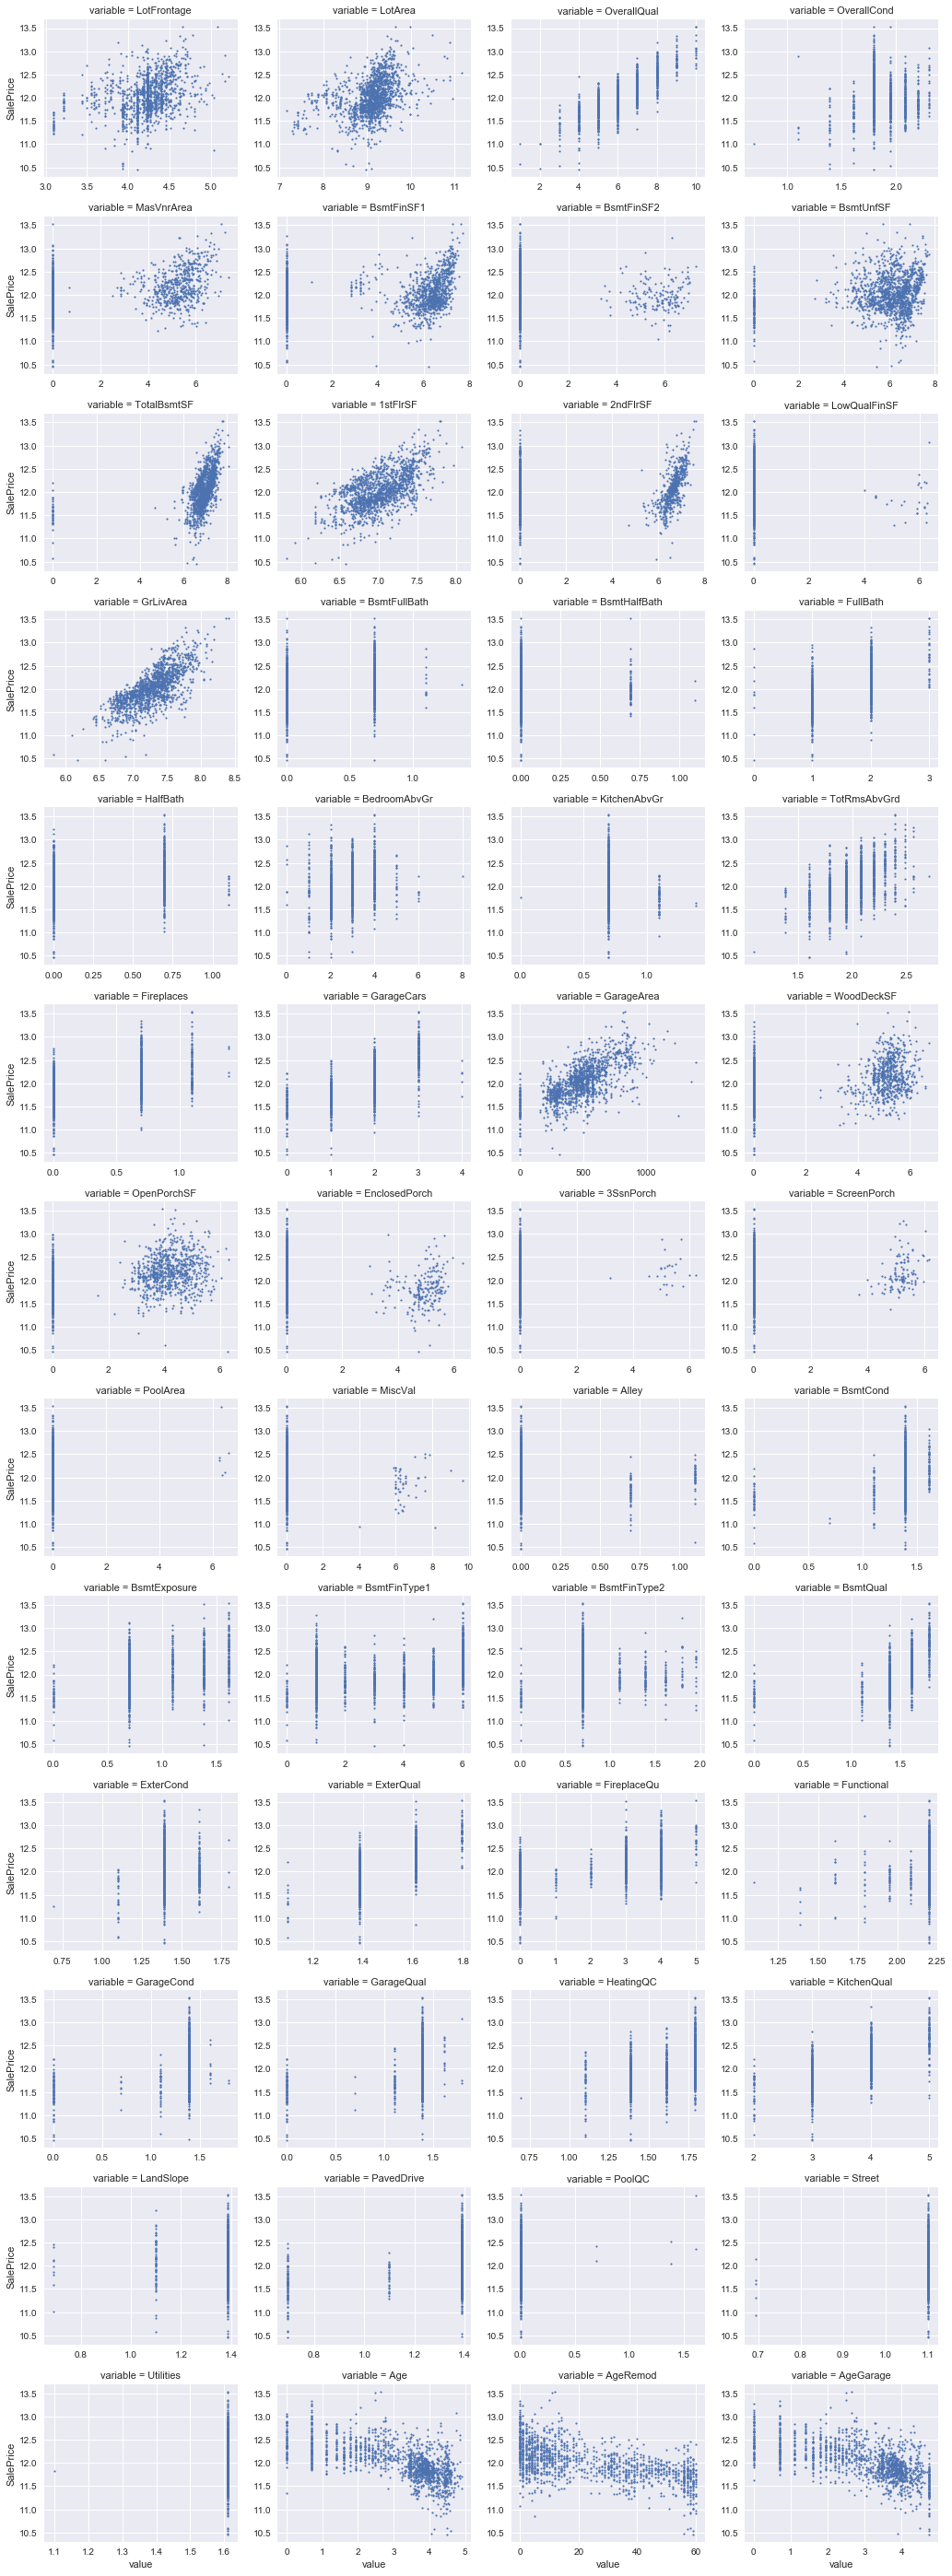

In [15]:
# scatter plots
temp = pd.melt(df, id_vars=['SalePrice'],value_vars=quan)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=4 , size=3.0, 
                     aspect=1.2,sharex=False, sharey=False)
grid.map(plt.scatter, "value",'SalePrice', s=3)
plt.show()

For the categorical features, I will transform them to dummy variables, but I'll drop one column from each of them to avoid [dummy variable trap](http://www.algosome.com/articles/dummy-variable-trap-regression.html). 

In [16]:
# create of list of dummy variables that I will drop, which will be the last
# column generated from each categorical feature
dummy_drop = []
for i in qual:
    dummy_drop += [ i+'_'+str(df[i].unique()[-1]) ]

# create dummy variables
df = pd.get_dummies(df,columns=qual) 
# drop the last column generated from each categorical feature
df = df.drop(dummy_drop,axis=1)

Now I can split the data into training set and test set. And then I'll perform Standardization on the numerical features (those that are not dummy variables). Here I use RobustScaler instead, which is more robust to outliers in the data.

In [17]:
X_train  = df[:-1459].drop(['SalePrice','Id'], axis=1)
y_train  = df[:-1459]['SalePrice']
X_test  = df[-1459:].drop(['SalePrice','Id'], axis=1)

# fit the training set only, then transform both the training and test sets
scaler = RobustScaler()
X_train[quan]= scaler.fit_transform(X_train[quan])
X_test[quan]= scaler.transform(X_test[quan])

X_train.shape, X_test.shape # now we have 220 features!

((1453, 220), (1459, 220))

## Feature Selection ##

Now there are 220 features due to a large amount of the dummy variables. Overfitting can easily occur when there are redundant features, which also leads to longer computation time. Therefore I use XGBoost regressor to generate the rank of "feature importance"

In [18]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = X_train.columns)
imp = imp.sort_values(['Importance'], ascending = False)

print(imp)

                       Importance
GrLivArea                0.097770
LotArea                  0.060034
OverallQual              0.060034
OverallCond              0.054889
BsmtFinSF1               0.044597
TotalBsmtSF              0.042882
1stFlrSF                 0.041166
Age                      0.041166
GarageArea               0.036021
Functional               0.027444
OpenPorchSF              0.027444
AgeRemod                 0.024014
BsmtExposure             0.022298
2ndFlrSF                 0.020583
AgeGarage                0.018868
MSZoning_C (all)         0.018868
LotFrontage              0.018868
BsmtUnfSF                0.017153
SaleCondition_Abnorml    0.013722
Neighborhood_Crawfor     0.013722
BsmtFinSF2               0.013722
EnclosedPorch            0.012007
WoodDeckSF               0.012007
Exterior1st_BrkFace      0.010292
ScreenPorch              0.010292
SaleType_New             0.010292
HouseStyle_1.5Fin        0.010292
BsmtQual                 0.008576
BsmtFinType1  

Now we can use [RFECV](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) to eliminate the redundant features.

In [19]:
# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

# Define a function to calculate negative RMSE (as a score)
def nrmse(y_true, y_pred):
    return -1.0*rmse(y_true, y_pred)

neg_rmse = make_scorer(nrmse)

estimator = XGBRegressor()
selector = RFECV(estimator, cv = 3, n_jobs = -1, scoring = neg_rmse)
selector = selector.fit(X_train, y_train)

print("The number of selected features is: {}".format(selector.n_features_))

features_kept = X_train.columns.values[selector.support_] 
X_train = X_train[features_kept]
X_test = X_test[features_kept]

The number of selected features is: 56


In [20]:
# These are the selected features 
features_kept

array(['1stFlrSF', '2ndFlrSF', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFullBath', 'BsmtQual', 'BsmtUnfSF',
       'EnclosedPorch', 'ExterQual', 'FireplaceQu', 'FullBath',
       'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageQual', 'GrLivArea', 'HalfBath', 'HeatingQC', 'KitchenAbvGr',
       'KitchenQual', 'LotArea', 'LotFrontage', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'Age',
       'AgeRemod', 'AgeGarage', 'MSZoning_C (all)', 'MSZoning_FV',
       'MSZoning_RL', 'MSZoning_RM', 'LotShape_Reg',
       'Neighborhood_Crawfor', 'Neighborhood_OldTown',
       'Neighborhood_StoneBr', 'Condition1_Artery', 'Condition1_Norm',
       'HouseStyle_1.5Fin', 'RoofStyle_Flat', 'Exterior1st_AsbShng',
       'Exterior1st_BrkFace', 'MasVnrType_Stone', 'CentralAir_Y',
       'SaleType_New', 'SaleCondition_Abnorml', 'MSSubClass_class2'], dtype=ob

## Modeling and Prediction ##

Kernel Ridge regressor is the model that performed best among the several models (XGBoost, Neural Network, Random Forest...etc) I have tried. Here I tune its hyperparameters using ``RandomizedSearchCV``.

In [21]:
ridge = KernelRidge()

parameters = {'alpha': uniform(0.05, 1.0), 'kernel': ['polynomial'], 
              'degree': [2], 'coef0':uniform(0.5, 3.5)}

random_search = RandomizedSearchCV(estimator = ridge,
                                   param_distributions = parameters,
                                   n_iter = 1000,
                                   cv = 3,
                                   scoring = neg_rmse,
                                   n_jobs = -1,
                                   random_state=0)

random_search = random_search.fit(X_train, y_train)

print("Parameters of the best_estimator:")
print(random_search.best_params_)
print("Mean cross-validated RMSE of the best_estimator: {}".format(-random_search.best_score_))
model = random_search.best_estimator_
print("RMSE of the whole training set: {}".format(rmse(y_train, model.predict(X_train))))

Parameters of the best_estimator:
{'alpha': 0.68083180840980384, 'coef0': 3.9929790032748049, 'degree': 2, 'kernel': 'polynomial'}
Mean cross-validated RMSE of the best_estimator: 0.111374934203
RMSE of the whole training set: 0.0929824904633


In [22]:
# Make predictions on the test set
y_pred = np.exp(model.predict(X_test))
output = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': y_pred})
output.to_csv('prediction.csv', index=False)